In [38]:
# Source code inspired by Dusmanu et al. (2019) and adapted to own needs
# https://github.com/mihaidusmanu/d2-net/tree/master/hpatches_sequences

# Import necessary libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.io import loadmat

In [3]:
%matplotlib inline

In [4]:
top_k = None 
n_i = 52
n_v = 56
dataset_path = 'hpatches_sequences/hpatches-sequences-release'

In [21]:
# List of methods, names, colors and linestyles (Configurations)
methods = ["sift", "siftSOS", "keynet", "disk"]
names = ['SIFT', 'SIFT-Affnet-SOSNet', 'KeyNet-AffNet-HardNet', 'DISK']
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']
linestyles = ['-', '-', '-', '-']

In [22]:
# Range for pixel threshold error
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [30]:
def mnn_matcher(descriptors_a, descriptors_b):
    """
    Performs mutual nearest neighbor matching of two sets of descriptors
    
    Parameters:
        descriptors_a: descriptors of shape [N, D]
        descriptors_b: descriptors of shape [M, D]
    Returns:
        matches: array of shape [num_matches, 2] with indices of matched descriptors
    """

    device = descriptors_a.device

    descriptors_a = descriptors_a.squeeze()
    descriptors_b = descriptors_b.squeeze()
    
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])

    return matches.t().data.cpu().numpy()

In [31]:
# Set computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [36]:
def benchmark_features(read_feats):
    """
    Computes matching stats (per image type, per domain change, per threshold) for every method

    Parameters:
        read_feats: function that reads features for a given image and returns keypoints and descriptors
    Returns:
        i_err: dictionary with matching stats for illumination sequences
        v_err: dictionary with matching stats for viewpoint sequences
        stats: list of [sequence type, number of features, number of matches] for each algorithm
        i_err_first: dictionary with matching stats for small domain change in illumination (first to second image)
        i_err_fifth: dictionary with matching stats for large domain change in illumination (first to sixth image)
        v_err_first: dictionary with matching stats for small domain change in viewpoint (first to second image)
        v_err_fifth: dictionary with matching stats for large domain change in viewpoint (first to sixth image)
    """

    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    i_err_first = i_err.copy()
    i_err_fifth = i_err.copy()
    v_err_first = v_err.copy()
    v_err_fifth = v_err.copy()

    for seq_idx, seq_name in enumerate(seq_names):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))

            pos_a = keypoints_a[matches[:, 0], : 2]

            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                error_val = np.mean(dist <= thr)
                
                if seq_name[0] == 'i':
                    i_err[thr] += error_val
                    if im_idx == 2:  
                        i_err_first[thr] += error_val
                    elif im_idx == 6:  
                        i_err_fifth[thr] += error_val
                else:
                    v_err[thr] += error_val
                    if im_idx == 2:  
                        v_err_first[thr] += error_val
                    elif im_idx == 6:  
                        v_err_fifth[thr] += error_val
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches], i_err_first, i_err_fifth, v_err_first, v_err_fifth

In [35]:
def summary(stats):
    """
    Computes summary statistics for number of keypoints and matches

    Parameters:
        stats: algorithm statistics returned by benchmark_features function
    Returns:
        n_feats: array of shape [num_images, num_methods] with number of keypoints for each image
        n_matches: array of shape [num_images, num_methods] with number of matches for each image pair
    """
    
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )
    return n_feats, n_matches

In [33]:
def generate_read_function(method, extension='ppm'):
    """
    Generates function to read features/descriptors for a given method

    Parameters:
        method: name of the method
        extension: extension of the files
    Returns:
        read_function: function to read features/descriptors for a given image
    """

    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if top_k is None:
            return aux['keypoints'], aux['descriptors']
        else:
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
    return read_function

In [24]:
# Define dir for results
if top_k is None:
    cache_dir = 'res'
else:
    cache_dir = 'cache-top'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [23]:
# Initialize error dict
errors = {}

In [27]:
# Calculate errors for each method (if not already calculated)
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    read_function = generate_read_function(method)
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-5])

sift
Loading precomputed errors...
# Features: 2048.000000 - [2048, 2048]
# Matches: Overall 751.127778, Illumination 820.469231, Viewpoint 686.739286
siftSOS
Loading precomputed errors...
# Features: 1735.990741 - [190, 2050]
# Matches: Overall 759.061111, Illumination 688.088462, Viewpoint 824.964286
keynet
Loading precomputed errors...
# Features: 1890.833333 - [514, 2048]
# Matches: Overall 950.744444, Illumination 957.426923, Viewpoint 944.539286
disk
Loading precomputed errors...
# Features: 2045.162037 - [1363, 2048]
# Matches: Overall 1048.762963, Illumination 1206.257692, Viewpoint 902.517857


# Plotting

In [25]:
# Pixel error threshold to be plotted
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

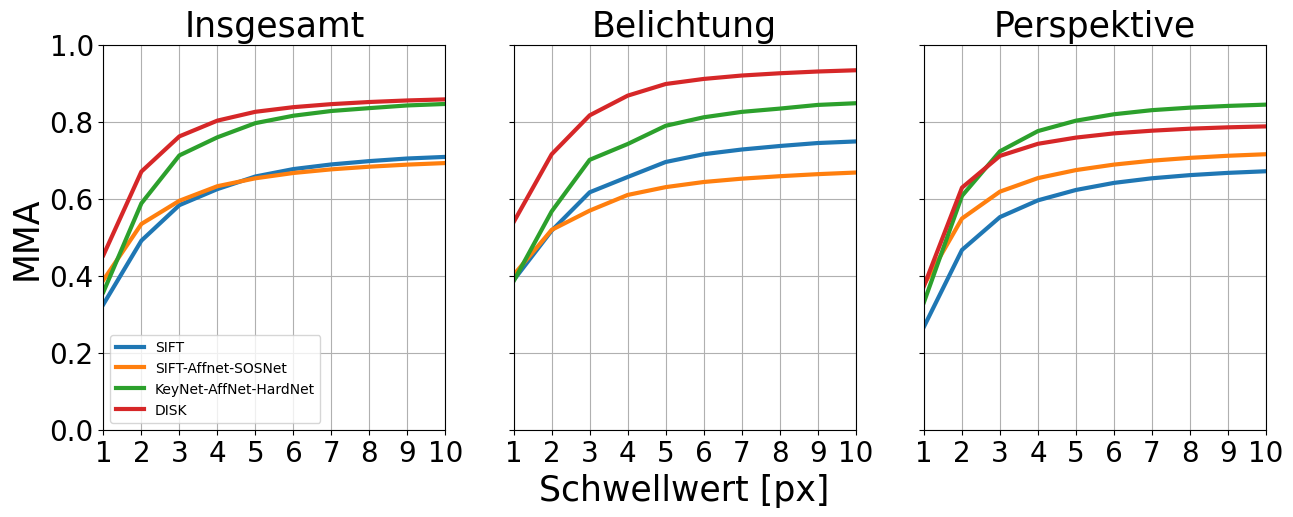

In [28]:
# Plot displaying results by image type
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _, _, _, _, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Insgesamt')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _, _, _, _, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Belichtung')
plt.xlabel('Schwellwert [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _, _, _, _, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Perspektive')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

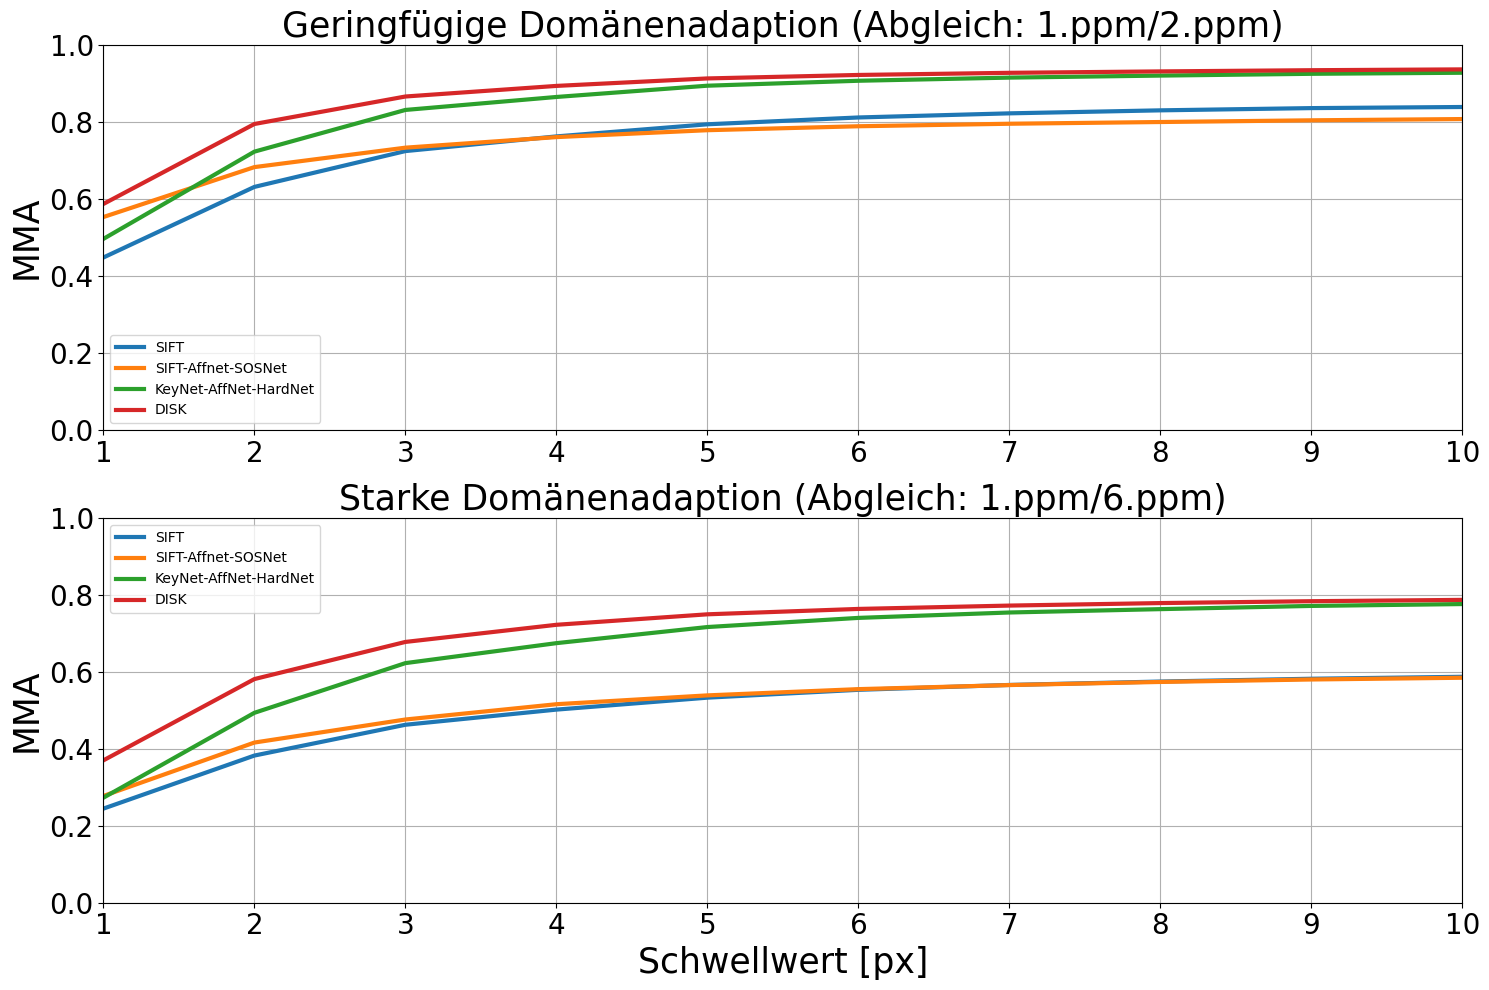

In [29]:
# Plot displaying results by domain change
plt.figure(figsize=(15, 10))

# Small domain change
plt.subplot(2, 1, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    _, _, _, i_err_first, _, v_err_first, _ = errors[method]
    plt.plot(plt_rng, [(i_err_first[thr] + v_err_first[thr]) / (n_i + n_v) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Geringfügige Domänenadaption (Abgleich: 1.ppm/2.ppm)')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

# Large domain change
plt.subplot(2, 1, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    _, _, _, _, i_err_fifth, _, v_err_fifth = errors[method]
    plt.plot(plt_rng, [(i_err_fifth[thr] + v_err_fifth[thr]) / (n_i + n_v) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Starke Domänenadaption (Abgleich: 1.ppm/6.ppm)')
plt.xlabel('Schwellwert [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.tight_layout()
